# Project 2

## MSDS7331: Data Mining
## Section 0403
## Summer 2018
- Anthony Schams
- Laura Ludwig  
- David Stroud
- Joshua Balson

## Data Preparation 
### Data Preparation Part 1
#### Define and Prepare Class Variables

##### Import Necessary packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import datetime as dt
import warnings
import string
import time
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict,GridSearchCV, ShuffleSplit,StratifiedShuffleSplit 
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier


/Users/anthonyschams/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### Import the data

In [3]:


df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

df_train['text'] = df_train.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                                        str(row['project_essay_2']), 
                                                        str(row['project_essay_3']), 
                                                        str(row['project_essay_4'])]), axis=1
                                                      )                               

df = df_train

stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182080 entries, 0 to 182079
Data columns (total 20 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

#### Variable Clean-up

Due to a change in the application questions, we must combine the responses for two questions in the earlier period to equate to one response in the later period. Prior to the change, the first two questions asked the teacher to introduce their students using two questions: one about their classroom and another describing their students. The later format has one question requesting the teacher to describe their students. The third and fourth questions in the prior period asked about the project details, which is addressed in the second question in the later period. We combined the text to create two variables: student_desc and proj_desc, to capture these two topics in comparable variables. Once we've created those, we remove the project_essay_x variables from the dataframe.  

In [4]:
# Create comparable variables based on the changes to the application questions that happened during the middle of the time period
df['student_desc'] = np.where(df['project_submitted_datetime']<'2016-05-17',df['project_essay_1']+' '+df['project_essay_2'],df['project_essay_1'])
df['proj_desc'] = np.where(df['project_submitted_datetime']<'2016-05-17',df['project_essay_3']+' '+df['project_essay_4'],df['project_essay_2'])

# Remove attributes that arent useful
if 'project_essay_1' in df:
    del df['project_essay_1']
if 'project_essay_2' in df:    
    del df['project_essay_2']
if 'project_essay_3' in df:
    del df['project_essay_3']
if 'project_essay_4' in df:    
    del df['project_essay_4']

Because one of our analysis tasks is to predict whether we can identify projects that address core academic competencies (reading, writing, and math), we create a variable called "three_r" to identify this as a category distinctly. We also add in the essay word lengths for essays one and two.  We perform a log transform on the continuous variables to correct for right-skew.  Finally, we create dummy variables for 'teacher_prefix' and 'project_grade_category'.

In [5]:
#https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


df["three_r"] = np.logical_or(df["project_subject_categories"].str.contains("Literacy & Language")
                             ,df["project_subject_categories"].str.contains("Math & Science")
                             )

# drop rows that still had missing values after grouped imputation
df.dropna(inplace=True)

# extract length of each essay and title
df['essay1_DescribeStudents_len'] = df['student_desc'].apply(len)
df['essay2_AboutProject_len'] = df['proj_desc'].apply(len)
df['title_len'] = df['project_title'].apply(len)

# take natural log of right skewed attributes
df['teacher_number_of_previously_posted_projects']=np.log1p(df.teacher_number_of_previously_posted_projects)
df['Total_Cost']=np.log1p(df.Total_Cost)
df['True_Quantity']=np.log1p(df.True_Quantity)
df['Average_item_cost']=np.log1p(df.Average_item_cost)
df['essay1_DescribeStudents_len']=np.log1p(df.essay1_DescribeStudents_len)
df['essay2_AboutProject_len']=np.log1p(df.essay2_AboutProject_len)
df['title_len']=np.log1p(df.title_len)

# perform one-hot encoding of the categorical data
tmp_df = pd.get_dummies(df.teacher_prefix,prefix='teacher_prefix')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.project_grade_category,prefix='project_grade_category')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Keep these attributes
df = df[['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost','project_is_approved'
        ,'teacher_prefix_Teacher','project_grade_category_Grades PreK-2'
        ,'essay1_DescribeStudents_len','essay2_AboutProject_len','title_len','text'
        ,'three_r','student_desc','proj_desc']]

# preserve final dataset
df2 = df.copy()
    
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182073 entries, 0 to 182079
Data columns (total 14 columns):
teacher_number_of_previously_posted_projects    182073 non-null float64
Total_Cost                                      182073 non-null float64
True_Quantity                                   182073 non-null float64
Average_item_cost                               182073 non-null float64
project_is_approved                             182073 non-null int64
teacher_prefix_Teacher                          182073 non-null uint8
project_grade_category_Grades PreK-2            182073 non-null uint8
essay1_DescribeStudents_len                     182073 non-null float64
essay2_AboutProject_len                         182073 non-null float64
title_len                                       182073 non-null float64
text                                            182073 non-null object
three_r                                         182073 non-null bool
student_desc                       

,teacher_number_of_previously_posted_projects,Total_Cost,True_Quantity,Average_item_cost,project_is_approved,teacher_prefix_Teacher,project_grade_category_Grades PreK-2,essay1_DescribeStudents_len,essay2_AboutProject_len,title_len
count,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000
mean,1.440580,6.021158,2.330753,3.916123,0.847676,0.021486,0.405821,6.486513,6.696629,3.429738
std,1.318374,0.740747,1.039543,1.282055,0.359335,0.144998,0.491052,0.274325,0.294957,0.407495
min,0.000000,4.313212,0.693147,0.230229,0.000000,0.000000,0.000000,4.304065,5.517453,1.609438
25%,0.000000,5.514759,1.609438,2.891869,1.000000,0.000000,0.000000,6.261492,6.466145,3.135494
50%,1.098612,5.990964,2.302585,3.848531,1.000000,0.000000,0.000000,6.424869,6.608001,3.433987
75%,2.302585,6.549365,3.091042,4.918228,1.000000,0.000000,1.000000,6.680855,6.875232,3.737670
max,6.113682,9.700169,7.247793,9.210340,1.000000,1.000000,1.000000,7.923348,8.561210,4.955827


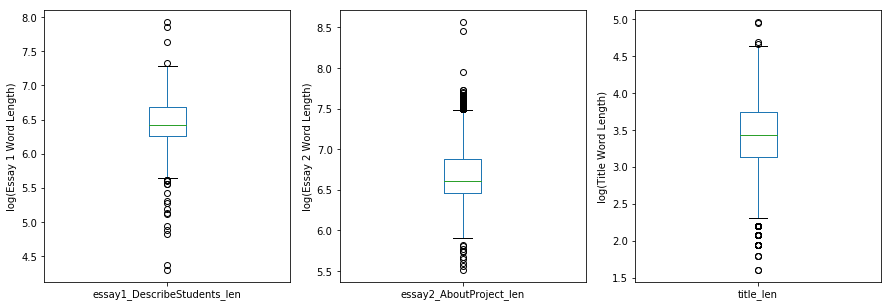

In [5]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
df.essay1_DescribeStudents_len.plot(kind='box')
plt.ylabel('log(Essay 1 Word Length)')
plt.subplot(1,3,2)
df.essay2_AboutProject_len.plot(kind='box')
plt.ylabel('log(Essay 2 Word Length)')
plt.subplot(1,3,3)
df.title_len.plot(kind='box')
plt.ylabel('log(Title Word Length)')
plt.show()

The boxplots above show the three new features added to this data set after the log transform has been applied

### Data Preparation Part 2

In [9]:
# Need description here, maybe a few visualizations

## Modeling and Evaluation

### Modeling and Evaluation 1: Evaluation Metrics

In [13]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 

    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)
    

def EvaluateClassifierEstimator3(classifierEstimator, X, y, cv):
    
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2)

    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        classifierEstimator.fit(X[train_indices],y[train_indices])  # train object
        y_hat = classifierEstimator.predict(X[test_indices]) # get test set precitions

        # print the accuracy and confusion matrix 
        print("====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

Our evaluation will come in two steps. First, models will be evaluated via gridsearch. The model with the highest accuracy will be selected as best. This model will then be evaluated for not only accuracy, but precision and recall as well. If these results are suspicious, we will examine confusion matrices of the model which will hopefully illuminate any issues present. 

We will be using accuracy to select the best model because we believe neither false positives nor false negatives are significantly more 'important' than the other. In the case of project approval, approving a subpar project is equally as undesired as failing to approve a good project. This is on the assumption that all projects proposed do have some value for the students being represented. There is also the additional requirement of raising the donations, so a subpar project that was approved will not necessarily recieve the funding requested. On the other hand, a good project that was incorrectly rejected can potentially be improved further and resubmitted for approval. Because this hypothetical project is good, it will likely recieve funding. 

In the case of the core competencies versus non-core competencies, false positives and false negatives are also treated equally. The purpose of the core competencies classification is to draw attention to the distinctions between these two classes of request. This can hopefully help identify the major differences in the resources requested and provided for the two classes of projects. The text analysis could possibly help identify the language used between the classes, which could reveal the differing attitudes that teachers have towards each of these classes of subjects. In both of these cases, incorrect classifications of either type are equal, as they both skew these results in similar ways. 

We will then use precision and recall to help compare the models if their accuracies are similar. This is especially important as some of the models built in the past simply approved all projects. This of course gave a high accuracy and recall, but was not a useful model. 

### Modeling and Evaluation 2: Train/Test Splits

We will generally be using 10-fold cross validation for training and testing our models. The exceptstions to this is with some of the text data models, 3-fold cross validation is used instead in the interest of time. The full dataset is also used for this process for all models except K-nearest neighbors. 50% of the data will be used for training and testing this model. 
We will be using standard cross validation (as opposed to stratified). This is because while the dataset is imbalanced, it is also large enough to include a large number of successes and failures in a randomly selected subset.

### Classification/Regression Models
We will create three different models for two different tasks.

-Task1:  predict whether an application will be approved or declined

-Task2:  predict whether an application project is one of the three Rs (Reading, Writing, Arithmetic) based on the essay text

### Modeling and Evaluation 3
#### Task 1:  Predicting Application Approval
##### Set Variables for Task 1

In [6]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

# we want to predict the X and y data as follows:
y = df['project_is_approved'].values # get the labels we want
X = df[['teacher_number_of_previously_posted_projects'
       ,'Total_Cost'
       ,'True_Quantity'
       ,'Average_item_cost'
       ,'teacher_prefix_Teacher'
       ,'project_grade_category_Grades PreK-2'
       ,'essay1_DescribeStudents_len'
       ,'title_len'
       ,'three_r'
       ]].values # use these to predict

In [7]:
# Create and fit our Tfidf Vectorizer
vectorizer = TfidfVectorizer()
x_text = vectorizer.fit_transform(df['text'])

##### Logistic Regression Model (Non-text Data)

In [9]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

#Logisitic regression 10-fold cross-validation 

regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100]
              ,'class_weight': ['balanced']
              ,'random_state': [0]
              ,'solver': ['sag'] #['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  

LogisticReg_GS= GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
LogisticReg_GS.fit(X, y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:  1.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced'], 'random_state': [0], 'solver': ['sag'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [10]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
#Display the best estimator parameters
print(EvaluateClassifierEstimator(LogisticReg_GS.best_estimator_, X, y, 10))


The average accuracy for all cv folds is: 			 0.56716
The average precision for all cv folds is: 			 0.88733
The average recall for all cv folds is: 			 0.56056
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall
0  0.571013   0.890563  0.563107
1  0.568981   0.889105  0.561552
2  0.565466   0.887333  0.558248
3  0.569859   0.882394  0.568291
4  0.566321   0.886089  0.560451
5  0.564179   0.886905  0.556887
6  0.570934   0.889513  0.563885
7  0.569177   0.890111  0.561034
8  0.559290   0.880938  0.555138
9  0.566352   0.890327  0.557053


In [11]:
LogisticReg_GS_res_df = pd.DataFrame(LogisticReg_GS.cv_results_)
print('Best Logistic Regression Estimator:',LogisticReg_GS.best_estimator_)
print('Accuracy of this Estimator:',LogisticReg_GS.best_score_)
print('Average fit time:',np.mean(LogisticReg_GS_res_df['mean_fit_time']))

Best Logistic Regression Estimator: LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)
Accuracy of this Estimator: 0.5663884007029877
Average fit time: 4.91134786605835


##### Decision Tree Classification (Non-Text Data)

In [12]:
dt_clf = DecisionTreeClassifier()
dt_GS_params= {'class_weight':['balanced'],
              'criterion':['gini', 'entropy'],
              'min_samples_split':[500,1000,5000],
              'min_samples_leaf':[250,500]}

dt_gridsearch = GridSearchCV(estimator = dt_clf,
                            param_grid = dt_GS_params,
                            n_jobs=4,
                            verbose=1,
                             cv=cv,
                            scoring='accuracy')
dt_gridsearch.fit(X,y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   47.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'class_weight': ['balanced'], 'criterion': ['gini', 'entropy'], 'min_samples_split': [500, 1000, 5000], 'min_samples_leaf': [250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [13]:
print(EvaluateClassifierEstimator(dt_gridsearch.best_estimator_, X, y, 10))

The average accuracy for all cv folds is: 			 0.5855
The average precision for all cv folds is: 			 0.89356
The average recall for all cv folds is: 			 0.58013
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall
0  0.584084   0.897945  0.574640
1  0.586775   0.892751  0.582480
2  0.587654   0.891369  0.584813
3  0.580789   0.894428  0.573085
4  0.587137   0.891427  0.584100
5  0.591366   0.898108  0.584230
6  0.583951   0.890956  0.580213
7  0.588894   0.891306  0.586562
8  0.581150   0.893787  0.574122
9  0.583159   0.893538  0.577010


In [14]:
dt_gridsearch_res_df = pd.DataFrame(dt_gridsearch.cv_results_)
print('Best Decision Tree Estimator:',dt_gridsearch.best_estimator_)
print('Accuracy of this Estimator:',dt_gridsearch.best_score_)
print('Average fit time:',np.mean(dt_gridsearch_res_df['mean_fit_time']))

Best Decision Tree Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=500, min_samples_split=5000,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of this Estimator: 0.5848692882249561
Average fit time: 1.2012304127216336


#### Decision Tree (Text Data)

In [15]:
dt_clf = DecisionTreeClassifier()
dt_GS_params= {'class_weight':['balanced'],
              'criterion':['gini'],
              'min_samples_split':[500,1000,2500],
              'min_samples_leaf':[250,500]}

dt_gridsearch_text = GridSearchCV(estimator = dt_clf,
                            param_grid = dt_GS_params,
                            n_jobs=-1,
                            verbose=1,
                            scoring='accuracy')
dt_gridsearch_text.fit(x_text,y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'class_weight': ['balanced'], 'criterion': ['gini'], 'min_samples_split': [500, 1000, 2500], 'min_samples_leaf': [250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [16]:
print(EvaluateClassifierEstimator(dt_gridsearch_text.best_estimator_, x_text, y, 10))

The average accuracy for all cv folds is: 			 0.60455
The average precision for all cv folds is: 			 0.8976
The average recall for all cv folds is: 			 0.60219
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall
0  0.604130   0.899320  0.600168
1  0.591718   0.898248  0.584554
2  0.610062   0.893187  0.613321
3  0.604844   0.898212  0.602047
4  0.616576   0.899216  0.616820
5  0.605152   0.901217  0.599974
6  0.613336   0.898424  0.613192
7  0.597243   0.892148  0.597058
8  0.605152   0.901764  0.599521
9  0.597276   0.894286  0.595283


In [17]:
dt_gridsearch_text_res_df = pd.DataFrame(dt_gridsearch_text.cv_results_)
print('Best Decision Tree Estimator:',dt_gridsearch_text.best_estimator_)
print('Accuracy of this Estimator:',dt_gridsearch_text.best_score_)
print('Average fit time:',np.mean(dt_gridsearch_text_res_df['mean_fit_time']))

Best Decision Tree Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=250, min_samples_split=2500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of this Estimator: 0.6162088832501249
Average fit time: 79.20594509442648


#### Naive Bayes - Multinomial (Non-Text Data)

In [18]:
mnb_clf = MultinomialNB()
mnb_params = {'alpha':[1e-10, 0.1,0.5, 1.0, 1.5],
             'fit_prior':[True, False]}
mnb_gridsearch = GridSearchCV(mnb_clf, 
                              param_grid = mnb_params,
                              cv = 10,
                              verbose = 1,
                              n_jobs=-1,
                              scoring = 'accuracy')
mnb_gridsearch.fit(X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [1e-10, 0.1, 0.5, 1.0, 1.5], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [19]:
print(EvaluateClassifierEstimator(mnb_gridsearch.best_estimator_, X, y, 10))

The average accuracy for all cv folds is: 			 0.84768
The average precision for all cv folds is: 			 0.84768
The average recall for all cv folds is: 			 1.0
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision  Recall
0  0.847649   0.847649     1.0
1  0.847649   0.847649     1.0
2  0.847649   0.847649     1.0
3  0.847649   0.847649     1.0
4  0.847696   0.847696     1.0
5  0.847696   0.847696     1.0
6  0.847696   0.847696     1.0
7  0.847696   0.847696     1.0
8  0.847696   0.847696     1.0
9  0.847688   0.847688     1.0


In [20]:
mnb_gridsearch_res_df = pd.DataFrame(mnb_gridsearch.cv_results_)
print('Best Multinomial Naive Bayes Estimator:',mnb_gridsearch.best_estimator_)
print('Accuracy of this Estimator:',mnb_gridsearch.best_score_)
print('Average fit time:',np.mean(mnb_gridsearch_res_df['mean_fit_time']))

Best Multinomial Naive Bayes Estimator: MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)
Accuracy of this Estimator: 0.847676481411302
Average fit time: 0.19022815704345702


##### Naive Bayes - Multinomial (Text Data)

In [21]:
mnb_clf_text = MultinomialNB()
mnb_params = {'alpha':[1e-10, 0.1,0.5, 1.0, 1.5],
             'fit_prior':[True, False]}
mnb_gridsearch_text = GridSearchCV(mnb_clf, 
                             param_grid = mnb_params,
                             cv = 10,
                             verbose = 1,
                             n_jobs=-1,
                             scoring = 'accuracy')
mnb_gridsearch_text.fit(x_text, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [1e-10, 0.1, 0.5, 1.0, 1.5], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [22]:
print(EvaluateClassifierEstimator(mnb_gridsearch_text.best_estimator_, x_text, y, 10))

The average accuracy for all cv folds is: 			 0.84762
The average precision for all cv folds is: 			 0.84771
The average recall for all cv folds is: 			 0.99985
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall
0  0.847540   0.847671  0.999806
1  0.847649   0.847688  0.999935
2  0.847594   0.847679  0.999870
3  0.847594   0.847679  0.999870
4  0.847696   0.847772  0.999870
5  0.847586   0.847679  0.999870
6  0.847641   0.847764  0.999806
7  0.847751   0.847781  0.999935
8  0.847586   0.847717  0.999806
9  0.847523   0.847701  0.999741


In [23]:
print(EvaluateClassifierEstimator3(mnb_gridsearch_text.best_estimator_, x_text, y, 10))

====Iteration 0  ====
accuracy 0.8506110119456268
confusion matrix
 [[    0  5435]
 [    5 30975]]
====Iteration 1  ====
accuracy 0.8454757654812577
confusion matrix
 [[    2  5626]
 [    1 30786]]
====Iteration 2  ====
accuracy 0.8493477962378141
confusion matrix
 [[    1  5482]
 [    4 30928]]
None


In [24]:
mnb_gridsearch_res_df = pd.DataFrame(mnb_gridsearch.cv_results_)
print('Best Multinomial Naive Bayes Estimator:',mnb_gridsearch.best_estimator_)
print('Accuracy of this Estimator:',mnb_gridsearch.best_score_)
print('Average fit time:',np.mean(mnb_gridsearch_res_df['mean_fit_time']))

Best Multinomial Naive Bayes Estimator: MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)
Accuracy of this Estimator: 0.847676481411302
Average fit time: 0.19022815704345702


#### K Nearest Neighbors (Non-Text Data)
Because our dataset is so large, we will be subsetting it to fit K-nearest Neighbors. With over 180,000 data points, this is necessary to train the model because of both memory and time limitations. Because of the size of the text data set, we will not be able to use it for K-nearest neighbors. 

In [ ]:
# Select a 50% subset of both the non-text and text datasets
X_sub, X_sub2, y_sub, y_sub2  = train_test_split(X, y, test_size=0.5, train_size=0.5)

In [27]:

knn = KNeighborsClassifier()

knn_params = {'n_neighbors':[3,15,25],
               'weights':['uniform', 'distance']}
knn_gridsearch = GridSearchCV(knn,
                                 param_grid = knn_params,
                                 cv = 10,
                                 verbose = 1,
                                 scoring='accuracy',
                                 n_jobs = -1)
knn_gridsearch.fit(X_sub, y_sub)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.0min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3, 15, 25], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [175]:
print(EvaluateClassifierEstimator(knn_gridsearch.best_estimator_, X, y, 10))

The average accuracy for all cv folds is: 			 0.99997
The average precision for all cv folds is: 			 0.99996
The average recall for all cv folds is: 			 0.99999
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall
0  1.000000   1.000000  1.000000
1  1.000000   1.000000  1.000000
2  1.000000   1.000000  1.000000
3  0.999945   0.999922  1.000000
4  0.999945   0.999922  1.000000
5  0.999890   0.999922  0.999922
6  1.000000   1.000000  1.000000
7  0.999945   0.999922  1.000000
8  0.999945   0.999922  1.000000
9  1.000000   1.000000  1.000000


In [176]:
knn_gridsearch_res_df = pd.DataFrame(knn_gridsearch.cv_results_)
print('Best Multinomial Naive Bayes Estimator:',knn_gridsearch.best_estimator_)
print('Accuracy of this Estimator:',knn_gridsearch.best_score_)
print('Average fit time:',np.mean(knn_gridsearch_res_df['mean_fit_time']))

Best Multinomial Naive Bayes Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')
Accuracy of this Estimator: 0.9999231073421504
Average fit time: 0.3658789118131002


#### Task 2: Predicting Core Academic Competency Projects (Reading, Writing, Math)
##### Preparing the Data

In [8]:
# we want to predict the X and y data as follows:
y2 = df['three_r'].values # get the labels we want
X2= X[:,:-1] # Select everything but the three_r column from X

#### Multinomial Naive-Bayes (Non-Text Data)

In [170]:
mnb = MultinomialNB()
mnb_params = {'alpha':[1e-10, 0.1, 0.25 ,0.5, 0.75, 1.0, 1.5],
             'fit_prior':[True, False]}
mnb_gridsearch_3r = GridSearchCV(mnb, 
                             param_grid = mnb_params,
                             cv = 10,
                              verbose = 1,
                            n_jobs=-1,
                             scoring = 'accuracy')
mnb_gridsearch_3r.fit(X2,y2)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   18.7s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [1e-10, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [131]:
print(EvaluateClassifierEstimator(mnb_gridsearch_3r.best_estimator_, X2, y2, 10))

The average accuracy for all cv folds is: 			 0.70239
The average precision for all cv folds is: 			 0.70239
The average recall for all cv folds is: 			 1.0
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision  Recall
0  0.702384   0.702384     1.0
1  0.702384   0.702384     1.0
2  0.702384   0.702384     1.0
3  0.702384   0.702384     1.0
4  0.702384   0.702384     1.0
5  0.702384   0.702384     1.0
6  0.702422   0.702422     1.0
7  0.702406   0.702406     1.0
8  0.702406   0.702406     1.0
9  0.702406   0.702406     1.0


The near-constant Accuracy and precision, as well as 100% recall, is highly suspicious. We therefore want to look at some of the confusion matrices.

In [132]:
print(EvaluateClassifierEstimator3(mnb_gridsearch_3r.best_estimator_, X2, y2, 10))

====Iteration 0  ====
accuracy 0.7017712481120417
confusion matrix
 [[    0 10860]
 [    0 25555]]
====Iteration 1  ====
accuracy 0.7068790333653714
confusion matrix
 [[    0 10674]
 [    0 25741]]
====Iteration 2  ====
accuracy 0.7034189207744062
confusion matrix
 [[    0 10800]
 [    0 25615]]
None


We see that we just approve all projects, which while accurate does not have much practical use.

In [133]:
mnb_GS_3r_res_df = pd.DataFrame(mnb_gridsearch_3r.cv_results_)
print('Best Multinomial Naive Bayes Estimator:',mnb_gridsearch_3r.best_estimator_)
print('Accuracy of this Estimator:',mnb_gridsearch_3r.best_score_)
print('Average fit time:',np.mean(mnb_GS_3r_res_df['mean_fit_time']))

Best Multinomial Naive Bayes Estimator: MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)
Accuracy of this Estimator: 0.7023940946763112
Average fit time: 0.12091413225446428


#### Multinomial Naive Bayes (Text Data)

In [134]:

mnb_params = {'alpha':[1e-10, 0.1, 0.25 ,0.5, 0.75, 1.0, 1.5],
             'fit_prior':[True, False]}
mnb_gridsearch_3r_text = GridSearchCV(mnb, 
                             param_grid = mnb_params,
                             cv = 10,
                              verbose = 1,
                             scoring = 'accuracy')
mnb_gridsearch_3r_text.fit(x_text,y2)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  1.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-10, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [136]:
print(EvaluateClassifierEstimator(mnb_gridsearch_3r_text.best_estimator_, x_text, y2, 10))

The average accuracy for all cv folds is: 			 0.84831
The average precision for all cv folds is: 			 0.89043
The average recall for all cv folds is: 			 0.89406
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall
0  0.854679   0.895315  0.898116
1  0.845782   0.889852  0.890687
2  0.852208   0.894515  0.895144
3  0.850011   0.892339  0.894362
4  0.847155   0.890493  0.892095
5  0.847485   0.889330  0.894128
6  0.841874   0.883040  0.893189
7  0.847688   0.890570  0.892868
8  0.849226   0.889777  0.896387
9  0.846974   0.889062  0.893650


In [137]:
mnb_GS_3r_text_res_df = pd.DataFrame(mnb_gridsearch_3r_text.cv_results_)
print('Best Multinomial Naive Bayes Estimator:',mnb_gridsearch_3r_text.best_estimator_)
print('Accuracy of this Estimator:',mnb_gridsearch_3r_text.best_score_)
print('Average fit time:',np.mean(mnb_GS_3r_text_res_df['mean_fit_time']))

Best Multinomial Naive Bayes Estimator: MultinomialNB(alpha=0.75, class_prior=None, fit_prior=False)
Accuracy of this Estimator: 0.8483080962031713
Average fit time: 0.5948449339185442


#### K-nearest Neighbors (Non-Text Data)
Because our dataset is so large, we will be subsetting it to fit K-nearest Neighbors. With over 180,000 data points, this is necessary to train the model because of both memory and time limitations. Because of the size of the text data set, we will not be able to use it for K-nearest neighbors. 

In [9]:
# Select a 50% subset of both the non-text and text datasets
X_sub3, X_sub4, y_sub3, y_sub4  = train_test_split(X2, y2, test_size=0.5, train_size=0.5)


In [144]:
knn = KNeighborsClassifier()

knn_params = {'n_neighbors':[3,15,25],
               'weights':['uniform', 'distance']}
knn_gridsearch_3r = GridSearchCV(knn,
                                 param_grid = knn_params,
                                 cv = 10,
                                 verbose = 1,
                                 scoring='accuracy',
                                 n_jobs = -1)

knn_gridsearch_3r.fit(X_sub3, y_sub3)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3, 15, 25], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

knn_gridsearch_3r_res_df = pd.DataFrame(knn_gridsearch_3r.cv_results_)
print('Best Multinomial Naive Bayes Estimator:',knn_gridsearch_3r.best_estimator_)
print('Accuracy of this Estimator:',knn_gridsearch_3r.best_score_)
print('Average fit time:',np.mean(knn_gridsearch_3r_res_df['mean_fit_time']))

#### Decision Tree (Non-Text Data)

In [11]:
dt_clf_3r = DecisionTreeClassifier()
dt_GS_3r_params= {'class_weight':['balanced'],
              'criterion':['gini', 'entropy'],
              'min_samples_split':[500,1000,5000],
              'min_samples_leaf':[250,500]}

dt_gridsearch_3r = GridSearchCV(estimator = dt_clf_3r,
                            param_grid = dt_GS_3r_params,
                            n_jobs=4,
                            verbose=1,
                             cv=cv,
                            scoring='accuracy')
dt_gridsearch_3r.fit(X2,y2)



Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   39.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'class_weight': ['balanced'], 'criterion': ['gini', 'entropy'], 'min_samples_split': [500, 1000, 5000], 'min_samples_leaf': [250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [14]:
print(EvaluateClassifierEstimator(dt_gridsearch_3r.best_estimator_, X2, y2, 10))


The average accuracy for all cv folds is: 			 0.60293
The average precision for all cv folds is: 			 0.77559
The average recall for all cv folds is: 			 0.6117
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall
0  0.606327   0.784090  0.606537
1  0.597045   0.769527  0.608570
2  0.601054   0.776444  0.606693
3  0.594409   0.775940  0.594104
4  0.602153   0.776669  0.608570
5  0.613082   0.773524  0.635077
6  0.598067   0.775118  0.602627
7  0.613040   0.776558  0.630513
8  0.604251   0.774889  0.615343
9  0.599857   0.773156  0.609008


In [179]:

dt_gridsearch_3r_res_df = pd.DataFrame(dt_gridsearch_3r.cv_results_)
print('Best Multinomial Naive Bayes Estimator:',dt_gridsearch.best_estimator_)
print('Accuracy of this Estimator:',dt_gridsearch_3r.best_score_)
print('Average fit time:',np.mean(dt_gridsearch_3r_res_df['mean_fit_time']))

Best Multinomial Naive Bayes Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=500, min_samples_split=5000,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of this Estimator: 1.0
Average fit time: 0.4836279471715292


#### Decision Tree (Text Data)

In [180]:
dt_clf_3r_text = DecisionTreeClassifier()
dt_GS_3r_text_params= {'class_weight':['balanced'],
              'criterion':['gini'],
              'min_samples_split':[500,1000,2500],
              'min_samples_leaf':[250,500]}

dt_gridsearch_3r_text = GridSearchCV(estimator = dt_clf,
                            param_grid = dt_GS_3r_text_params,
                            n_jobs=-1,
                            verbose=1,
                            scoring='accuracy')
dt_gridsearch_3r_text.fit(x_text,y2)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'class_weight': ['balanced'], 'criterion': ['gini'], 'min_samples_split': [500, 1000, 2500], 'min_samples_leaf': [250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [181]:
print(EvaluateClassifierEstimator(dt_gridsearch_3r_text.best_estimator_, x_text, y2, 10))

The average accuracy for all cv folds is: 			 0.7797
The average precision for all cv folds is: 			 0.89883
The average recall for all cv folds is: 			 0.77348
*********************************************************
Cross Validation Fold Mean Error Scores
   Accuracy  Precision    Recall
0  0.780811   0.898460  0.775588
1  0.781525   0.899882  0.775197
2  0.775483   0.904735  0.760419
3  0.774165   0.898210  0.765189
4  0.783337   0.895882  0.782469
5  0.784380   0.892411  0.788021
6  0.777119   0.899004  0.769098
7  0.782050   0.898806  0.777213
8  0.777106   0.906803  0.760870
9  0.781061   0.894143  0.780732


In [182]:

dt_gridsearch_3r_text_res_df = pd.DataFrame(dt_gridsearch_3r_text.cv_results_)
print('Best Multinomial Naive Bayes Estimator:',dt_gridsearch_3r_text.best_estimator_)
print('Accuracy of this Estimator:',dt_gridsearch_3r_text.best_score_)
print('Average fit time:',np.mean(dt_gridsearch_3r_text_res_df['mean_fit_time']))

Best Multinomial Naive Bayes Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=250, min_samples_split=2500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of this Estimator: 0.7760843178285632
Average fit time: 94.27424495750004


In [65]:
def ConfInt(a,n1,b,n2):
    sigma1 = (a * (1-a))/ n1
    sigma2 = (b * (1-b))/ n2
    CI_HW = 1.96 * np.sqrt(sigma1+sigma2)
    diff = b - a
    return((diff - CI_HW,diff+CI_HW))

knn_ci = ConfInt(0.83166, 36414, 0.83223, 36414)
print('Confidence Interval:[',knn_ci[0],',',knn_ci[1],']')

Confidence Interval:[ -0.004861374840361873 , 0.006001374840362014 ]


Because they are the most accurate models, we would like to know if this difference in accuracy between 7 nearest neighbors and 11 nearest neighbors is statistically significant. We therefore generate a confidence interval, assuming the population the data was selected from follow a binomial distribution. This confidence interval contains 0, so there is no statistical evidence that either of these models is better than the other. 

### Modeling and Evaluation 4: Analyze Results of Chosen Models

In [36]:
#need something here

### Modeling and Evaluation 5: Model Advantages

In [37]:
#need something here

### Modeling and Evaluation 6: Model Attribute Importance

In [30]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_sub) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data. It uses the last iteration of the loop above for the split.

X_train_scaled = scl_obj.transform(X_sub) # apply to training
X_test_scaled = scl_obj.transform(X_sub2) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticReg_GS.best_estimator_.fit(X_train_scaled, y_sub)

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_sub2,y_hat)
conf = mt.confusion_matrix(y_sub2,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

# now let's make a pandas Series with the names and values, and plot them
# reference for code: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb



accuracy: 0.5709107286048529
[[ 8243  5619]
 [33444 43731]]
Total_Cost has weight of -0.2117073086989212
teacher_prefix_Teacher has weight of -0.044375632708646716
True_Quantity has weight of -0.03849407467079832
project_is_approved has weight of -0.03179407164047795
essay2_AboutProject_len has weight of 0.05273180918331217
essay1_DescribeStudents_len has weight of 0.05477932778059977
project_grade_category_Grades PreK-2 has weight of 0.07046587888068516
teacher_number_of_previously_posted_projects has weight of 0.2317318873321855
Average_item_cost has weight of 0.2825875012963379


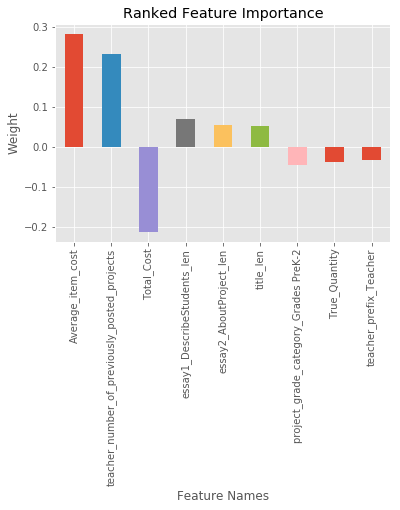

In [48]:
%matplotlib inline
plt.style.use('ggplot')

weights = lr_clf.coef_.ravel()
feature_names = df.columns.values

logreg_features = pd.DataFrame({'feature_names': np.concatenate((feature_names[:4],feature_names[5:10])), 
                                'weights': weights[:10], 
                                'absolute_weights':np.abs(weights[:10])})
logreg_features.sort_values(by='absolute_weights', inplace=True, ascending = False)

weights = pd.Series(logreg_features['weights'].values, index=logreg_features['feature_names'])
px = weights.plot(kind='bar')
px.set_xlabel("Feature Names")
px.set_ylabel("Weight")
px.set_title("Ranked Feature Importance")
plt.show()

## Deployment

Task 1 is a clearly valuable question to answer for DonorsChoose as an organization. By being able to accurately automate application approvals, the time spent reading applications will be reduced for volunteers. Because the organization is not actually funding these projects, but is just providing the vehicle by which to post a project to be crowd-funded, this will reduce the barriers to publishing projects and get more resources to teachers and students who need them. In doing so, it will leverage volunteer time to address gaps in applications that do not pass through the initial screening, making the projects more likely to succeed once they are posted. There are several measures to show the value of implementing an automation based on this model, one of which would be "volunteer-hours/# projects posted". Because non-profits highly value the time of their volunteers, and their primary goal is to post quality projects to be funded, a decrease in this measure, along with looking at the trend in each the numerator and denominators, would demonstrate value to the organization. This model would need to be updated yearly, or potentially on an ad hoc basis if there is anecdotal evidence to support revisiting the model. A yearly update would ensure that new technology terms are accounted for, as well as the maturity of the organization and the teachers leveraging their services.

The outcome of Task 2 is slightly less tangible, but is valuable, particularly for schools who may be looking to improve their core competencies. Examining the features that drive these projects that relate to core competencies can help identify where there are gaps in the foundational tools being provided to teachers for these subjects. This kind of analysis can be helpful in reforming the general education framework and provide better opportunities, to make sure that projects of this nature are not needed in the future. Policy makers and influencers could use the information to build a better system. To measure whether this is happening, additional data about the scores of students in these areas over time could be evaluated, along with the trend in the frequency of these projects. We would expect to see the scores of students improve while the number of requested projects goes down, which would loosely demonstrate that policy changes had been made. This model would also need to be refreshed yearly, or within a given time period after a policy change is enacted, to ensure that vocabulary is keeping up to date with the changes in teacher needs. It would be beneficial to also keep the original model in place, since teachers may shift their requests in these areas to be beyond the basic core competencies and be encouraging their students into deeper curiosity. Being able to benchmark with the same model would give stronger evidence of a change due to policy updates. 

## Exceptional Work

In [42]:
#need something here